# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [1]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import Synthetic2DViz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset and model names for file naming
DATASET_NAME = 'moons'
MODEL_NAME = 'neuralode'

Using device: cuda


## 1. Carregar Dataset


Figure saved to: ../results/figures/01_moons_neuralode.png


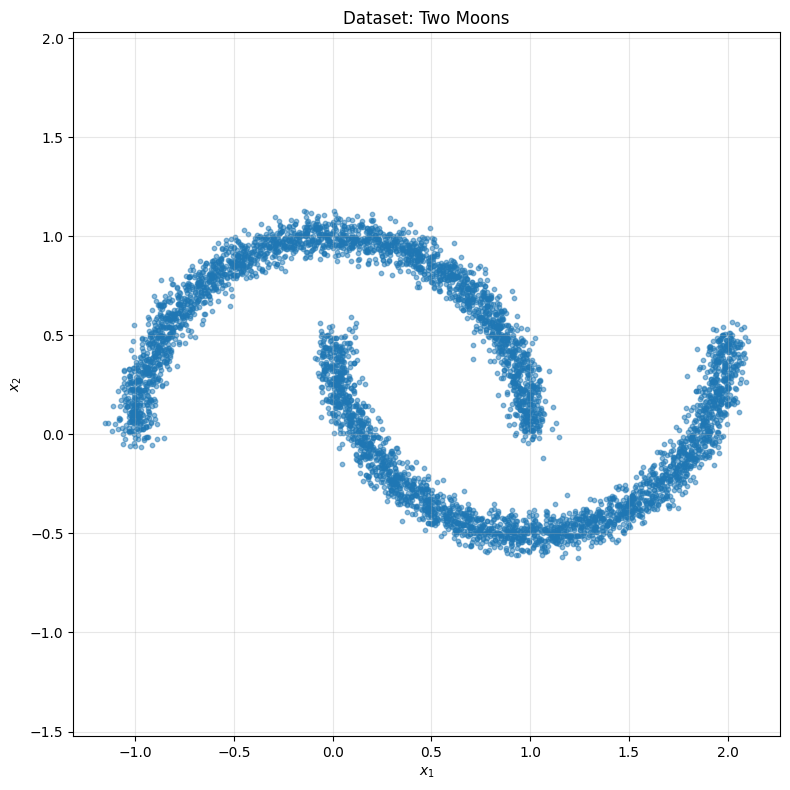

Dataset size: 5000


In [2]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type=DATASET_NAME)
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset.data,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}.png')
)
plt.tight_layout()
plt.show()
print(f"Dataset size: {len(dataset)}")

## 2. Criar e Treinar Modelo


In [25]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='euler',
    rtol=1e-5,
    atol=1e-5,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Treinar para classificação
train_neural_ode(model, dataloader, optimizer, device, num_epochs=100)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'01__{DATASET_NAME}_{MODEL_NAME}.pt'
)
torch.save(model.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Epoch 1/100: 100%|██████████| 40/40 [00:03<00:00, 12.39it/s]


Epoch 1, Loss: 0.090187


Epoch 2/100: 100%|██████████| 40/40 [00:03<00:00, 12.62it/s]


Epoch 2, Loss: 0.089570


Epoch 3/100: 100%|██████████| 40/40 [00:02<00:00, 14.89it/s]


Epoch 3, Loss: 0.071545


Epoch 4/100: 100%|██████████| 40/40 [00:02<00:00, 15.31it/s]


Epoch 4, Loss: 0.064801


Epoch 5/100: 100%|██████████| 40/40 [00:02<00:00, 14.72it/s]


Epoch 5, Loss: 0.048148


Epoch 6/100: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s]


Epoch 6, Loss: 0.043214


Epoch 7/100: 100%|██████████| 40/40 [00:02<00:00, 14.57it/s]


Epoch 7, Loss: 0.039826


Epoch 8/100: 100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


Epoch 8, Loss: 0.035230


Epoch 9/100: 100%|██████████| 40/40 [00:02<00:00, 13.88it/s]


Epoch 9, Loss: 0.031372


Epoch 10/100: 100%|██████████| 40/40 [00:03<00:00, 13.00it/s]


Epoch 10, Loss: 0.029241


Epoch 11/100: 100%|██████████| 40/40 [00:02<00:00, 13.66it/s]


Epoch 11, Loss: 0.029876


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 14.07it/s]


Epoch 12, Loss: 0.027567


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 13.94it/s]


Epoch 13, Loss: 0.018353


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s]


Epoch 14, Loss: 0.019995


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 14.47it/s]


Epoch 15, Loss: 0.015794


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 14.36it/s]


Epoch 16, Loss: 0.009288


Epoch 17/100:  18%|█▊        | 7/40 [00:00<00:03,  9.54it/s]


KeyboardInterrupt: 

## 3. Visualizar Trajetórias


Figure saved to: ../results/figures/01_moons_neuralode_trajectories.png


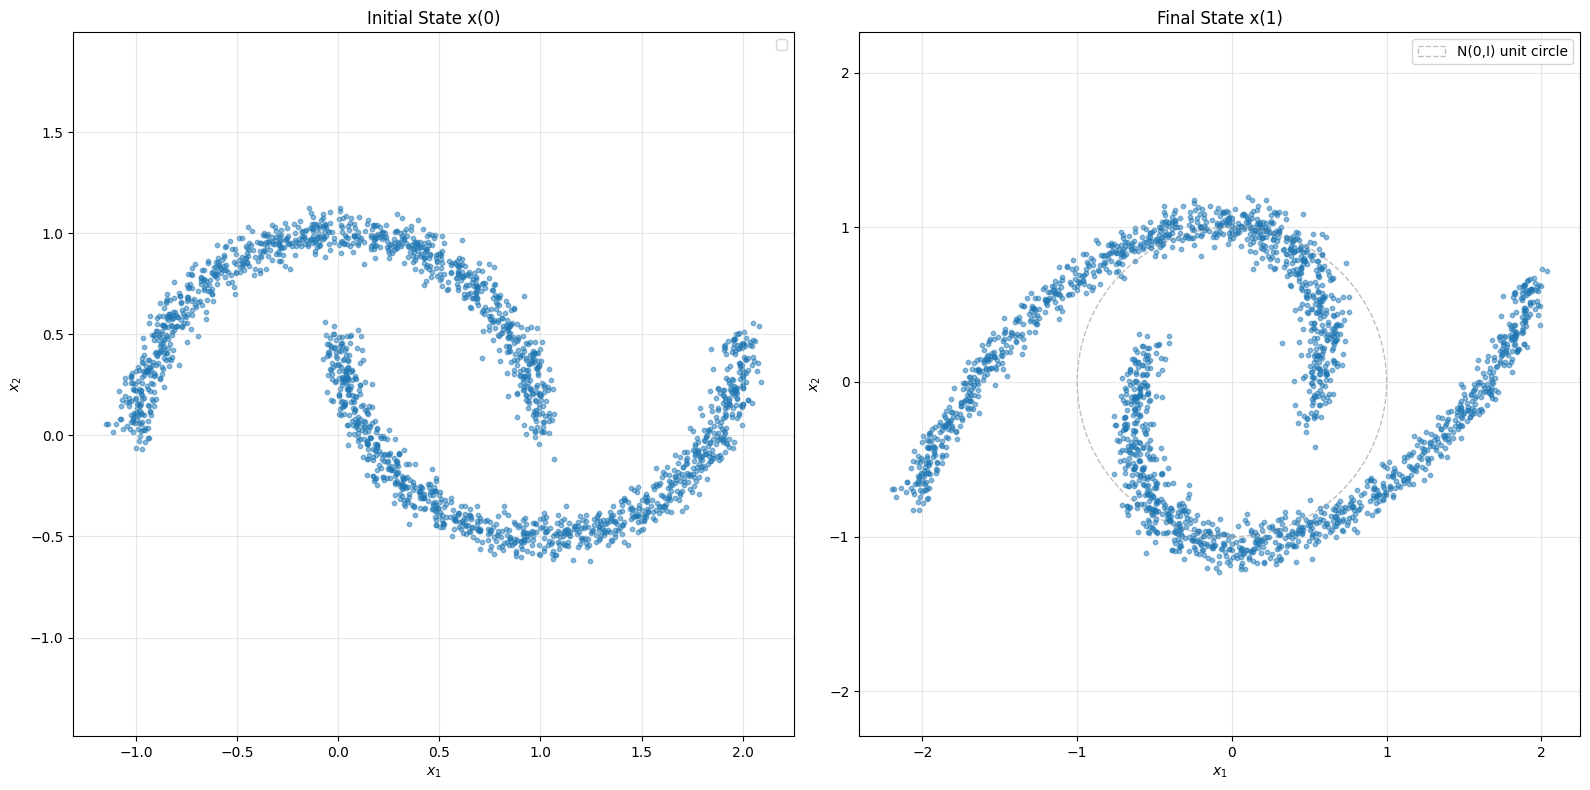

In [26]:
Synthetic2DViz.plot_trajectories(
    model,
    dataset,
    n_samples=2000,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_trajectories.png')
)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png
Figure saved to: ../results/figures/01_moons_neuralode_vector_fields.png


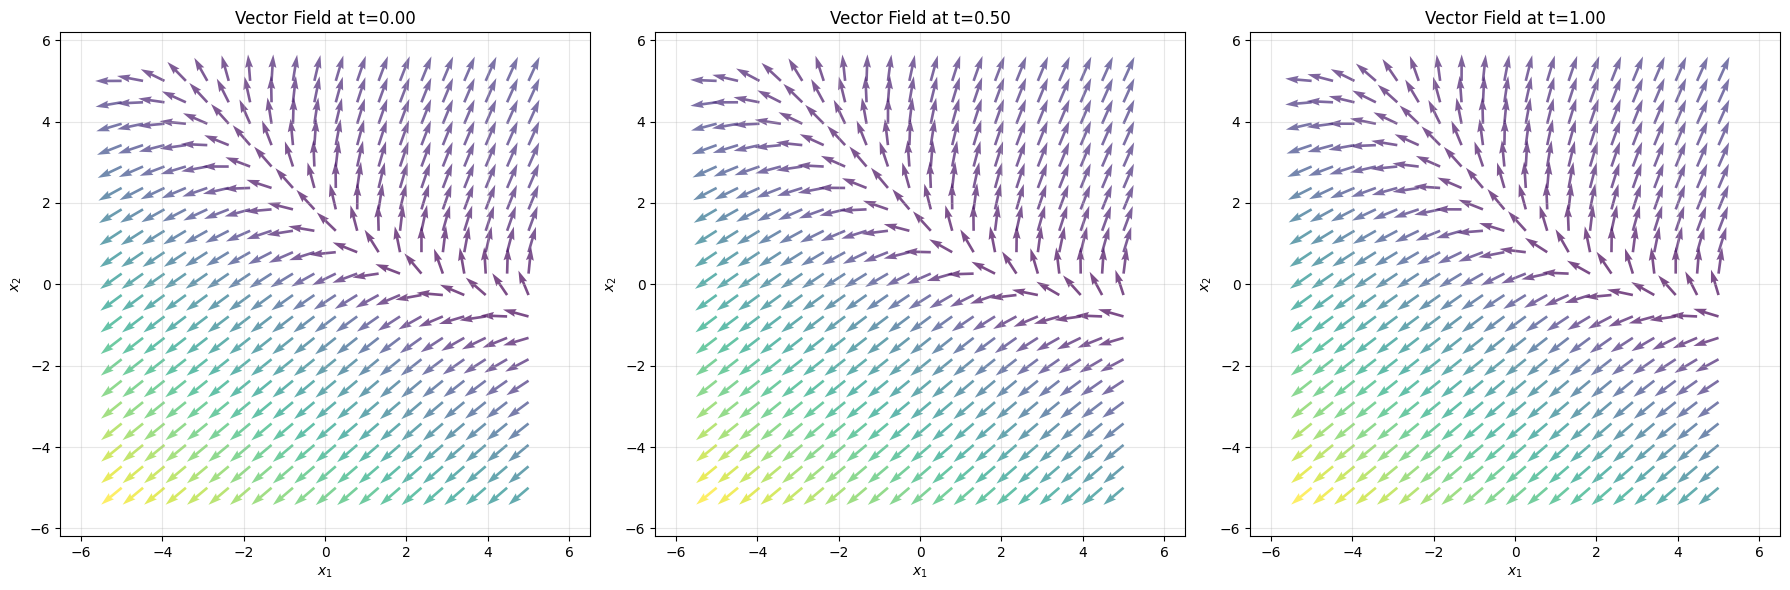

In [27]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        model,
        xlim=(-5, 5),
        ylim=(-5, 5),
        n_grid=20,
        t=t,
        ax=axes[i],
        save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_vector_fields.png')
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


Figure saved to: ../results/figures/01_moons_neuralode_transformation.png


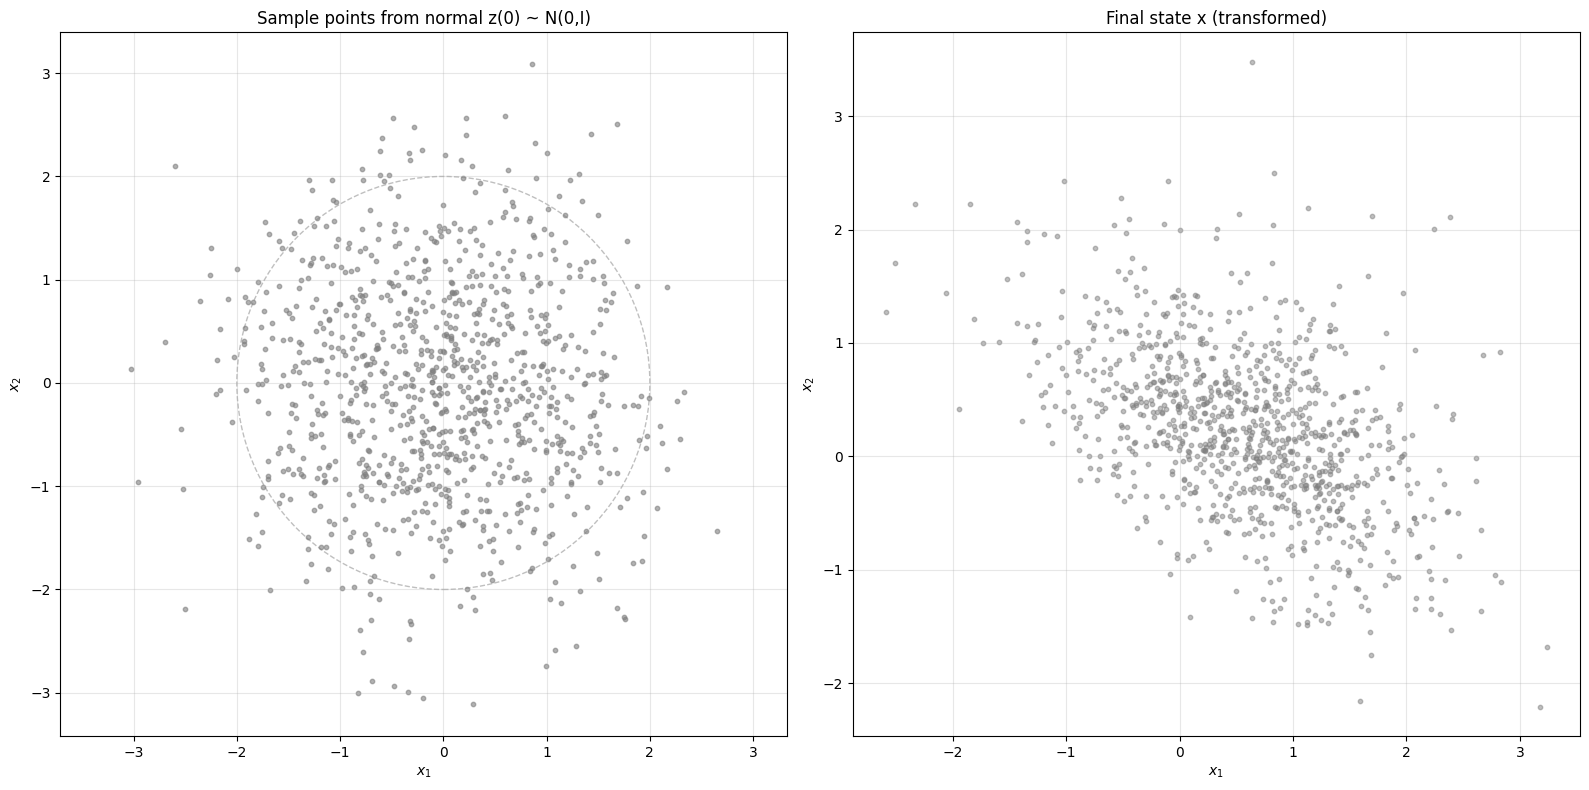

In [28]:
Synthetic2DViz.plot_transformation(
    model,
    n_samples=1000,
    n_steps=100,
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}_transformation.png')
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [ ]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
        n_outputs=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
        n_outputs=2
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")
